# 0. Setup

In [1]:
# pip install --user GitPython
# pip install --user rdkit

In [2]:
# Verify we're in the correct working directory
import os
import git 
from pathlib import Path

def get_project_root():
    return Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

root = get_project_root()

os.chdir(root)
os.getcwd()

'/Users/seraphinashi/Desktop/dmPC'

In [3]:
plot_folder = "images/GDSC/"

## import packages, models, trainers

In [4]:
import argparse
import logging
import sys
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

print('pytorch version:', torch.__version__)
print('orig num threads:', torch.get_num_threads())

/Users/seraphinashi/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


pytorch version: 1.13.1
orig num threads: 4


In [5]:
from models import *
from trainers import *
from losses import *
from utils import *
# from cpd_smiles_embed import *

In [6]:
import random
seed=42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Prepare dataset

## Load 

In [7]:
data_folder = "data/GDSC"
c_data = pd.read_csv(os.path.join(data_folder, "c_data.csv"), index_col = 0)
c_meta = pd.read_csv(os.path.join(data_folder, "c_meta.csv"), index_col = 0)
# RNAseq_meta['COSMIC_ID'] = RNAseq_meta['COSMIC_ID'].astype(int)

d_data = pd.read_csv(os.path.join(data_folder, "d_data.csv"), index_col = 0)

cdr = pd.read_csv(os.path.join(data_folder, "cdr.csv"), index_col = 0)

In [8]:
cdr.shape

(847, 174)

## Prepare data
Skin cancer

In [9]:
c_types = ["SKCM"] 

c_meta = c_meta[c_meta["cancer_type"].isin(c_types)]
c_data = c_data[c_data.index.isin(c_meta["COSMIC_ID"])]
cdr = cdr[cdr.index.isin(c_meta["COSMIC_ID"])]

In [10]:
cdr.shape

(54, 174)

In [11]:
# 1. prepare c_meta, 
c_meta_id_col_name = 'COSMIC_ID'
c_meta_type_col_name = 'cancer_type'

c_meta = c_meta[[c_meta_id_col_name, c_meta_type_col_name]]
c_meta = c_meta.rename(columns = {
    c_meta_id_col_name:'C_ID', 
    c_meta_type_col_name:'C_type'})
c_meta = c_meta[~c_meta['C_ID'].isnull()]

c_meta, meta_map = get_CCL_meta_codes(c_data.index.values, c_meta)
c_meta.index = c_meta.index.astype(str)

print(f"Cancer type coding map: ")
print(meta_map)

Cancer type coding map: 
  C_type  code  count
0   SKCM     0     54


In [12]:
column_counts = c_meta['code'].value_counts()
print(column_counts)

code
0    54
Name: count, dtype: int64


In [13]:
# 2. prepare c_data
## make sure: 
##   1. the index (row names) is cancer cell line names
c_data.index = c_data.index.astype(str)
c_data.shape

(54, 5703)

In [14]:
# 3. prepare d_data
## make sure: 
##   1. the index (row names) is drug names
# cpd_smiles = cpd_smiles[['drug_id', 'smiles']]
# cpd_smiles = cpd_smiles.set_index('drug_id')

# d_data = smiles_to_AtonBondDescriptor_PCAembedings(cpd_smiles)
d_data.index = d_data.index.astype(str)

d_data.shape

(174, 75)

In [15]:
# 4. prepare cdr
## make sure: 
##   1. the index (row names) is cancer cell line names
##   2. the columns (column names) is drug names
cdr.index = cdr.index.astype("str")

common_drugs = list(set(cdr.columns).intersection(set(d_data.index)))
cdr = cdr[common_drugs]
d_data = d_data.loc[common_drugs]

common_cancers = list(set(cdr.index).intersection(set(c_data.index)))
cdr = cdr.loc[common_cancers]
c_data = c_data.loc[common_cancers]
c_meta = c_meta.loc[common_cancers]

print(f'cdr shape: {cdr.shape}')
print(f'c_data shape: {c_data.shape}')
print(f'c_meta shape: {c_meta.shape}')
print(f'd_data shape: {d_data.shape}')

cdr shape: (54, 174)
c_data shape: (54, 5703)
c_meta shape: (54, 2)
d_data shape: (174, 75)


In [16]:
c_meta.head()

,code,k0
908124,0,1
910932,0,1
906793,0,1
905956,0,1
753581,0,1


# 2. Hyperparameters

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
print(device)

cpu


In [18]:
class Train_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    valid_size = 0.25 #@param {type: "float"}

    n_epochs = 250 #@param {type: "integer"}
    batch_size = None #@param {type: "integer"}
    lr = 0.01 #@param {type: "float"}
    
    C_VAE_loss_weight = 5 #@param {type: "float"}
    C_recon_loss_weight = 0.05 #@param {type: "float"}
    C_kld_weight = 1 #@param {type: "float"}
    C_cluster_distance_weight = 200 #@param {type: "float"}
    C_update_ratio_weight = 10 #@param {type: "float"}"}
    
    D_VAE_loss_weight = 5 #@param {type: "float"}
    D_recon_loss_weight = 1 #@param {type: "float"}
    D_kld_weight = 1 #@param {type: "float"}
    D_cluster_distance_weight = 100 #@param {type: "float"}
    D_update_ratio_weight = 10 #@param {type: "float"}
    
    predict_loss_weight = 4000 #@param {type: "float"}
    
    cVAE_save_path = 'data/model_fits/GDSC_skin_c_vae' #@param
    dVAE_save_path = 'data/model_fits/GDSC_skin_d_vae_skin' #@param
    
    c_p_save_path = 'data/model_fits/GDSC_skin_c_vae_predictor' #@param
    d_p_save_path = 'data/model_fits/GDSC_skin_d_vae_predictor' #@param

    rm_cluster_outliers = False #@param {type: "bool"}
    use_mixture_kld = True #@param {type: "bool"}
    use_weighted_bce = False #param {type: "bool"}



class CDPModel_sub_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    # c_VAE
    c_input_dim = 0 #@param {type: "integer"}
    c_h_dims = [1024, 512, 256, 128] #@param {type: "vactor"}
    c_latent_dim = 32 #@param {type: "integer"}

    # d_VAE
    d_input_dim = 0 #@param {type: "integer"}
    d_h_dims = [64]  #@param {type: "vactor"}
    d_latent_dim = 32 #@param {type: "integer"}

    # predictor
    p_sec_dim = 16 #@param {type: "integer"}
    p_h_dims = [p_sec_dim*2, 16]  #@param {type: "vactor"}
    
    # all
    drop_out = 0  #@param {type: "float"}
    
    # sensitive threshold
    sens_cutoff = 0.65
    


In [19]:
train_args = Train_Args()

K = len(c_meta[c_meta['code'] != -1]['code'].unique())

CDPmodel_args = CDPModel_sub_Args()
CDPmodel_args['c_input_dim'] = c_data.shape[1] 
CDPmodel_args['d_input_dim'] = d_data.shape[1]

if CDPmodel_args['c_input_dim'] <= 0:
  warnings.warn(
      '''\nCancer Cell line feature number not specified''')
if CDPmodel_args['d_input_dim'] <= 0:
  warnings.warn(
      '''\nDrug feature number not specified''')

# 3. Train Model

In [20]:
CDPmodel = CDPmodel(K, CDPmodel_args)


In [21]:
n_rounds = 5
fit_returns = CDPmodel.fit(
    c_data, c_meta, 
    d_data, cdr, 
    train_args, n_rounds = n_rounds, 
    search_subcluster = True, device = device)

=> Initialize C-VAE:


KeyboardInterrupt: 

In [ ]:
(c_meta, c_meta_hist, d_sens_hist, 
 losses_train_hist_list, best_epos_list, 
 C_VAE_init_losses, D_VAE_init_losses, 
 c_latent_list, d_latent_list) = fit_returns


In [ ]:
best_epos_list

[[[242, 118], [244, 153], [217, 24], [197, 218], [244, 207], None]]

# 4. Results and visualizations

In [ ]:
cdr_hat = CDPmodel.predict(c_data, d_data)

In [ ]:
cdr_train_hat = cdr_hat

cdr_train_rslt = cdr.copy()
cdr_train_rslt['c_name'] = cdr_train_rslt.index.values
cdr_train_rslt = pd.melt(cdr_train_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_train_rslt = cdr_train_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_train_rslt = pd.merge(cdr_train_rslt, cdr_train_hat, on=['c_name', 'd_name'], how='outer')

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Binary cross entropy
cdr_train_rslt_noNA = cdr_train_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_train = log_loss(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {round(binary_cross_entropy_train,4)}")


# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print("ROC AUC:", round(roc_auc, 4))

# confusion_ atrix
cdr_train_rslt_noNA['cdr_hat_bnr'] = (cdr_train_rslt_noNA['cdr_hat'] > 0.5).astype(int)

conf_matrix = confusion_matrix(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat_bnr'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")

Binary cross entropy: 5.061
ROC AUC: 0.5849

True Positive:  256 (18.12 %)
False Negative: 1157 (81.88 %)
True Negative:  6441 (98.82 %)
False Positive: 77 (1.18 %)


<ipython-input-26-a4f0d25fca13>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdr_train_rslt_noNA['cdr_hat_bnr'] = (cdr_train_rslt_noNA['cdr_hat'] > 0.5).astype(int)


In [ ]:
# output data

cdr_hat.to_csv(os.path.join(data_folder, "skin/GDSC_skin_cdr_hat.csv"), index=True)

c_latent = pd.DataFrame(c_latent_list[0][n_rounds-1])
c_latent.index = c_data.index
c_latent.to_csv(os.path.join(data_folder, "skin/GDSC_skin_c_latent_cluster1.csv"), index=True)

if CDPmodel.K == 2:
    c_latent_1 = pd.DataFrame(c_latent_list[1][n_rounds-1])
    c_latent_1.index = c_data.index
    c_latent_1.to_csv(os.path.join(data_folder, "skin/GDSC_skin_c_latent_cluster2.csv"), index=True)

    d_latent_1 = pd.DataFrame(d_latent_list[1][n_rounds-1])
    d_latent_1.index = d_data.index
    d_latent_1.to_csv(os.path.join(data_folder, "skin/GDSC_skin_d_latent_cluster2.csv"), index=True)
    
d_latent = pd.DataFrame(d_latent_list[0][n_rounds-1])
d_latent.index = d_data.index
d_latent.to_csv(os.path.join(data_folder, "skin/GDSC_skin_d_latent_cluster1.csv"), index=True)

In [ ]:
cdr_train_hat = CDPmodel.predict(c_data, d_data)

cdr_train_rslt = cdr.copy()
cdr_train_rslt['c_name'] = cdr_train_rslt.index.values
cdr_train_rslt = pd.melt(cdr_train_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_train_rslt = cdr_train_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})


cdr_train_rslt = pd.merge(cdr_train_rslt, cdr_train_hat, on=['c_name', 'd_name'], how='outer')

cdr_train_rslt

,c_name,d_name,cdr,cdr_hat,cdr_all,cluster,c_cluster,d_cluster
0,1299081,1237,0.0,0,0,-1,0,-1
1,909706,1237,0.0,0,0,-1,-1,-1
2,905977,1237,0.0,0,0,-1,0,-1
3,906813,1237,0.0,0,0,-1,0,-1
4,753581,1237,0.0,0,0,-1,0,-1
...,...,...,...,...,...,...,...,...
9391,905976,1825,0.0,0,0,-1,0,-1
9392,907169,1825,0.0,0,0,-1,-1,-1
9393,909724,1825,NaN,0,0,-1,-1,-1
9394,905956,1825,0.0,0,0,-1,0,-1


## Clusters

In [ ]:
print('Cancer clustering before:')
print(c_meta_hist.code.value_counts())
print('Cancer clustering after:')
print(c_meta_hist.code_sub_latest.value_counts())

Cancer clustering before:
code
0    54
Name: count, dtype: int64
Cancer clustering after:
code_sub_latest
0     47
-1     7
Name: count, dtype: int64


In [ ]:
c_meta_train_tmp = c_meta.loc[:, ['code']]
c_meta_train_tmp['c_name'] = c_meta_train_tmp.index.values.astype(str)
c_meta_train_tmp = c_meta_train_tmp.rename(columns={'code':'cluster_init'})

cdr_train_rslt_tmp = cdr_train_rslt[['c_name', 'cluster']]
cdr_train_rslt_tmp = cdr_train_rslt_tmp.drop_duplicates()
cdr_train_rslt_tmp['c_name'] = cdr_train_rslt_tmp['c_name'].astype(str)

cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_tmp, c_meta_train_tmp, on='c_name', how='left')

print("CD-bicluster:")
print(pd.crosstab(cdr_train_rslt_cluster['cluster_init'], cdr_train_rslt_cluster['cluster']))



CD-bicluster:
cluster       -1   0
cluster_init        
0             54  47


In [ ]:
cdr_train_rslt_tmp = cdr_train_rslt[['c_name', 'c_cluster']]
cdr_train_rslt_tmp = cdr_train_rslt_tmp.drop_duplicates()
cdr_train_rslt_tmp['c_name'] = cdr_train_rslt_tmp['c_name'].astype(str)

cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_tmp, c_meta_train_tmp, on='c_name', how='left')

print("Cancer cluster:")
print(pd.crosstab(cdr_train_rslt_cluster['cluster_init'], cdr_train_rslt_cluster['c_cluster']))


Cancer cluster:
c_cluster     -1   0
cluster_init        
0              7  47


In [ ]:
d_sens_hist

,sensitive_k0,sensitive_k0_b0,sensitive_k0_b1,sensitive_k0_b2,sensitive_k0_b3,sensitive_k0_b4,sensitive_k0_sub_b0,sensitive_k,sensitive_k_b0,sensitive_k_b1,sensitive_k_b2,sensitive_k_b3,sensitive_k_b4,sensitive_k_latest,sensitive_k_sub_b0,sensitive_k_sub_b1,sensitive_k_sub_b2,sensitive_k_sub_b3,sensitive_k_sub_b4,sensitive_k_sub_latest
1237,0,0,0,0,0,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2159,0,0,0,0,0,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1831,0,0,0,0,0,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1149,0,0,0,0,0,0,1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1029,0,0,0,0,0,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0,0,0,0,0,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1031,0,0,0,0,0,0,1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1615,0,0,0,0,0,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1581,0,0,0,0,0,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
print('Sensitive to clusters before:')
print(d_sens_hist.sensitive_k.value_counts())
print('Sensitive to clusters after:')
print(d_sens_hist.sensitive_k_sub_latest.value_counts())

Sensitive to clusters before:
sensitive_k
-1    168
0       6
Name: count, dtype: int64
Sensitive to clusters after:
sensitive_k_sub_latest
-1    166
0       8
Name: count, dtype: int64


## Visualizations

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

from visuals import *

{'-1': (0.4, 0.7607843137254902, 0.6470588235294118), '0': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)}


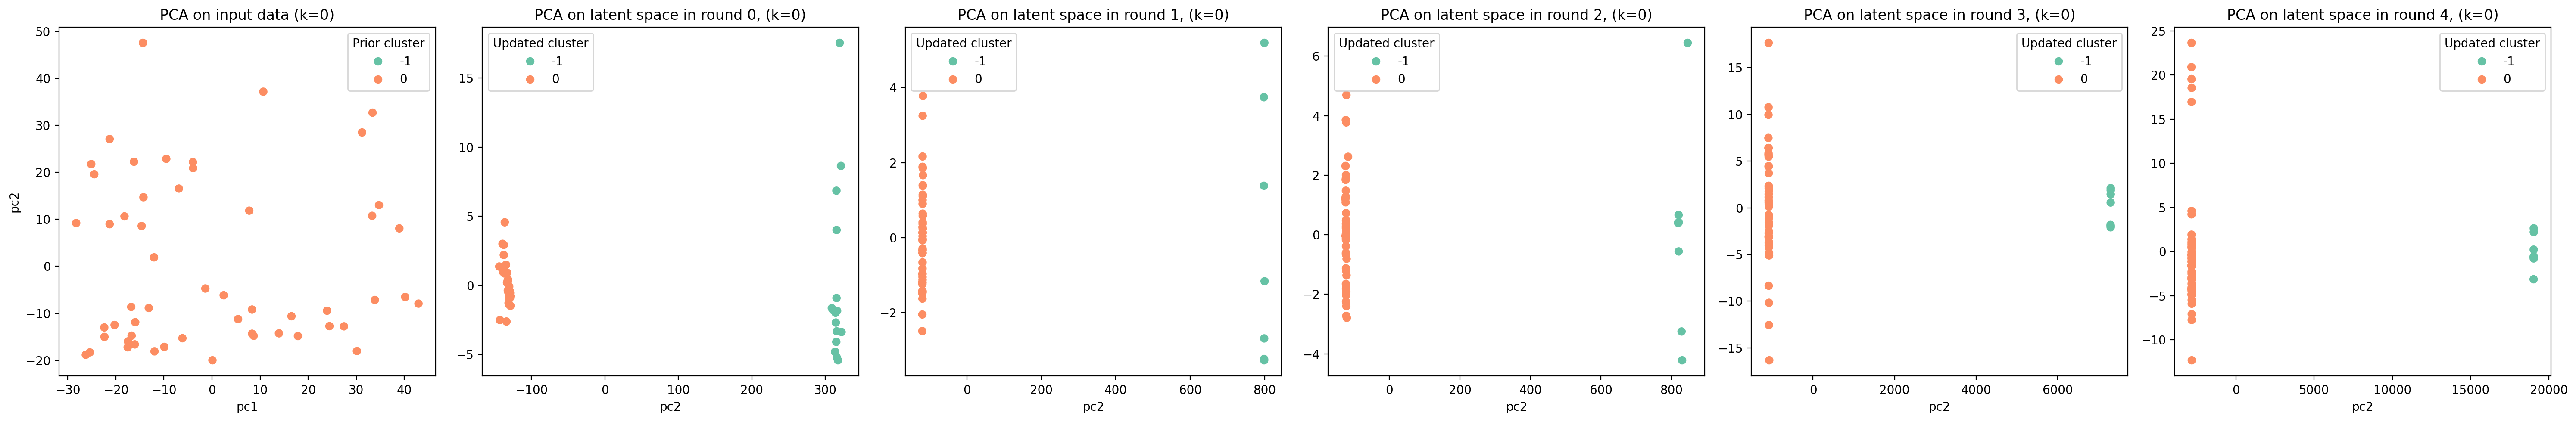

In [ ]:
# plot_c_PCA_latent(c_data, n_rounds, fit_returns, model=CDPmodel, plots_save_path=f'results/images/GDSC/GDSC_skin_c_latent')

plots_save_path = 'results/images/GDSC/GDSC_skin_c_latent'
for k in CDPmodel.which_non_empty_cluster:
    if k in CDPmodel.which_non_empty_subcluster:
        k_sub = CDPmodel.cluster_id_for_subcluster[CDPmodel.which_non_empty_subcluster.index(k)]
        plot_c_PCA_latent_help(c_data, c_latent_list, c_meta_hist, n_rounds, k=k, k_sub = k_sub, plot_save_path=f'{plots_save_path}_k{k}.png')
    else:
        plot_c_PCA_latent_help(c_data, c_latent_list, c_meta_hist, n_rounds, k=k, plot_save_path=f'{plots_save_path}_k{k}.png')


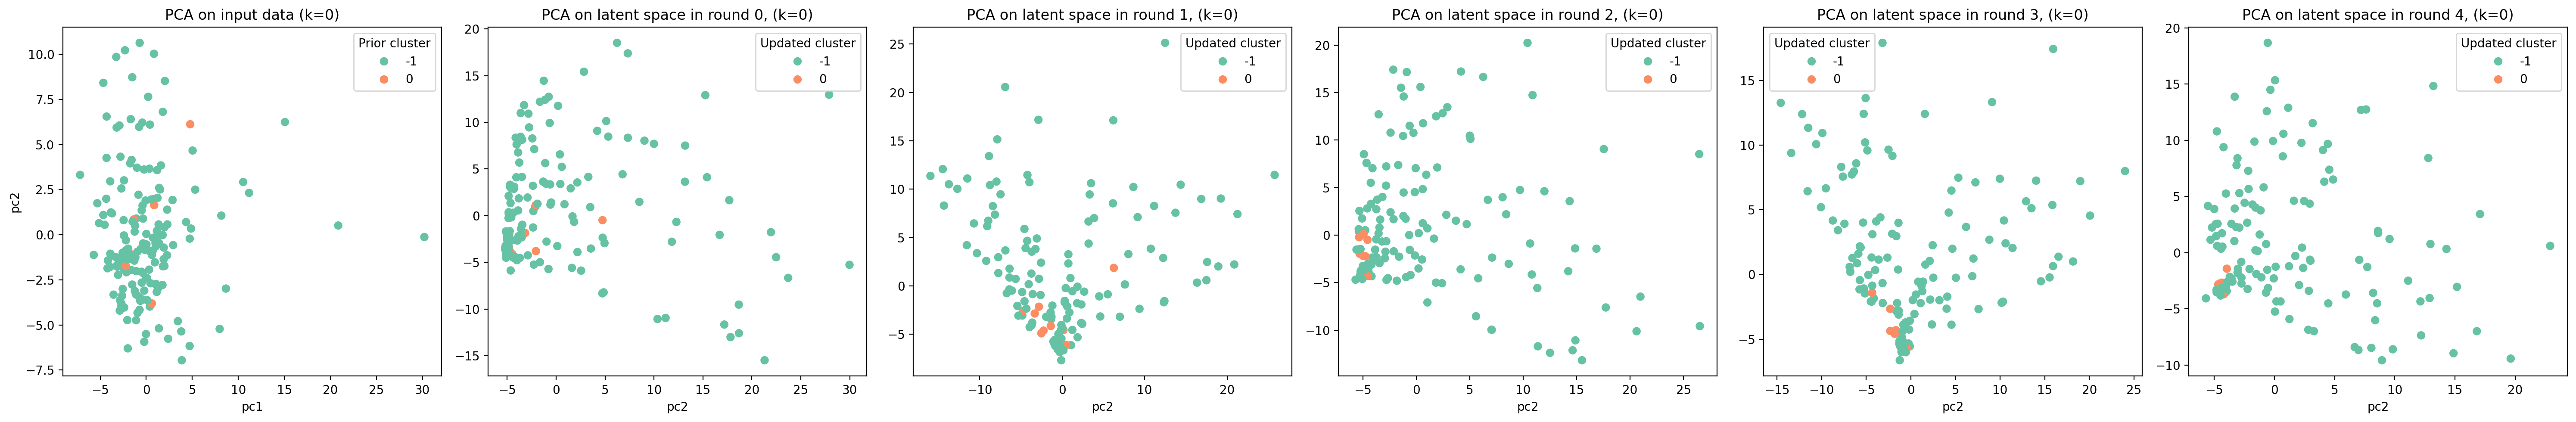

In [ ]:
plot_d_PCA_latent(d_data, n_rounds, fit_returns, model=CDPmodel, plots_save_path=f'results/images/GDSC/GDSC_skin_d_latent')


### Losses:

k = 0:
round 0:


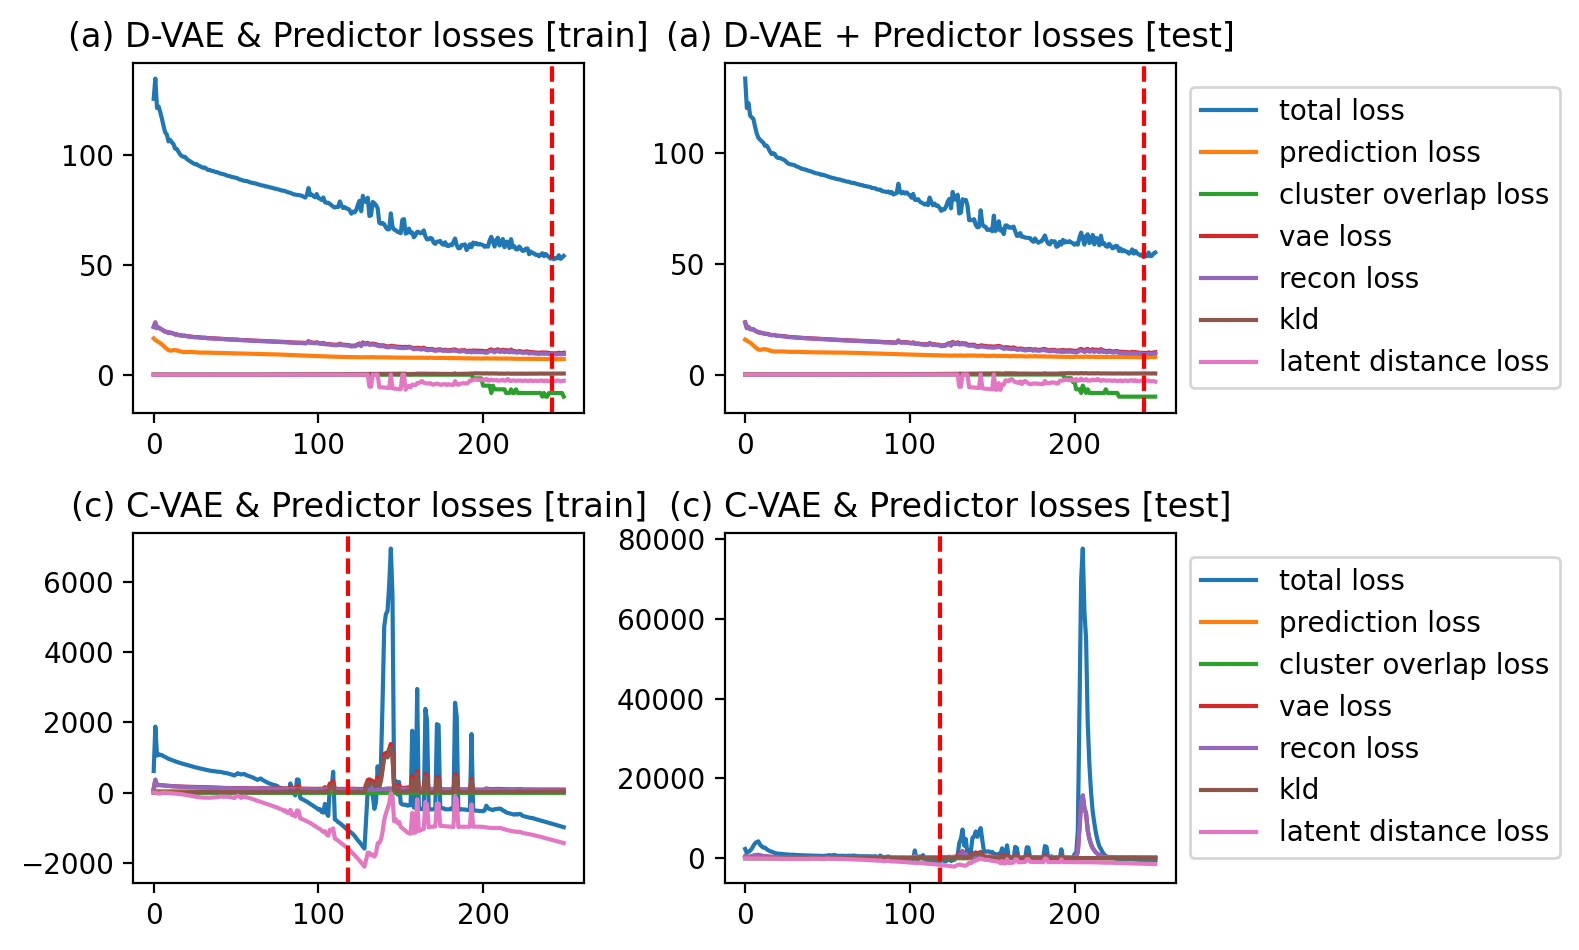

round 1:


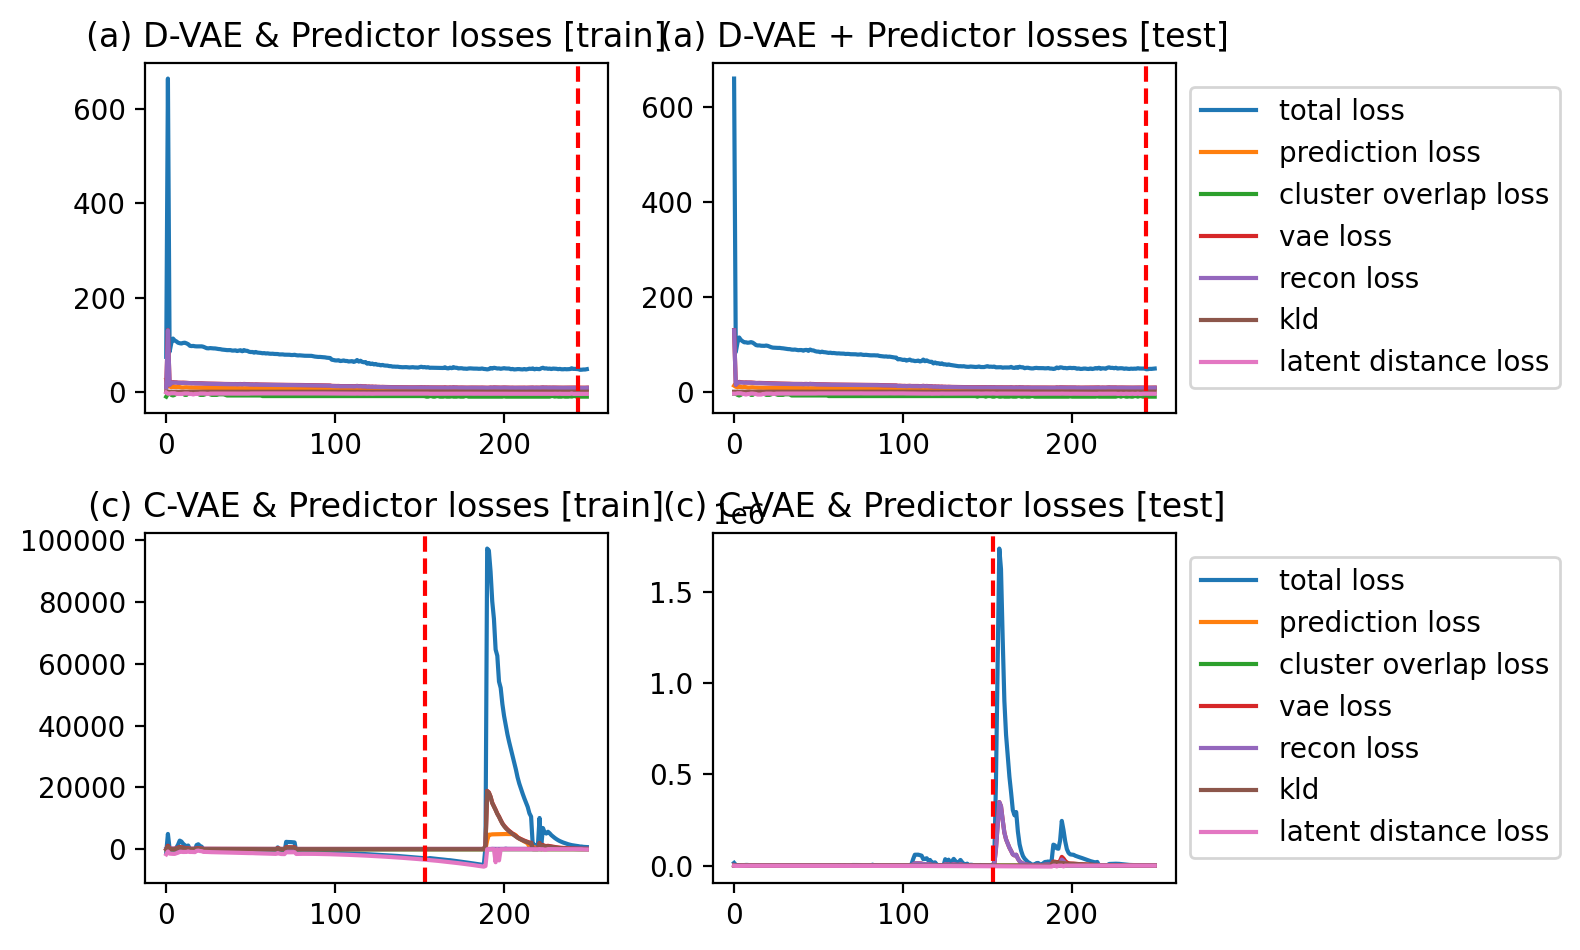

round 2:


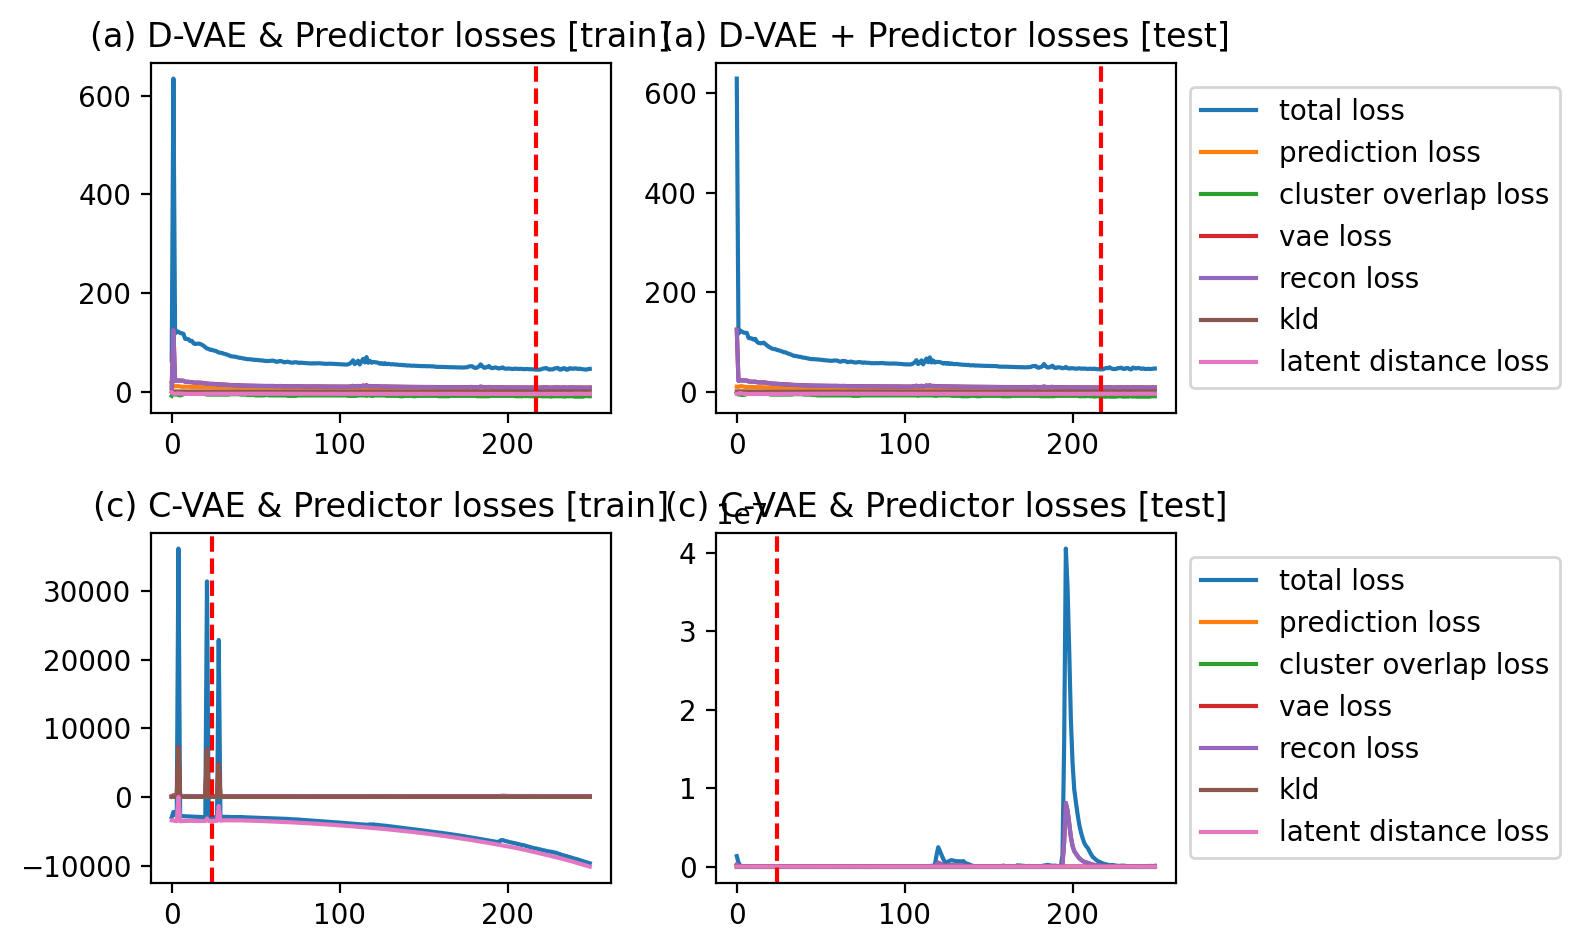

round 3:


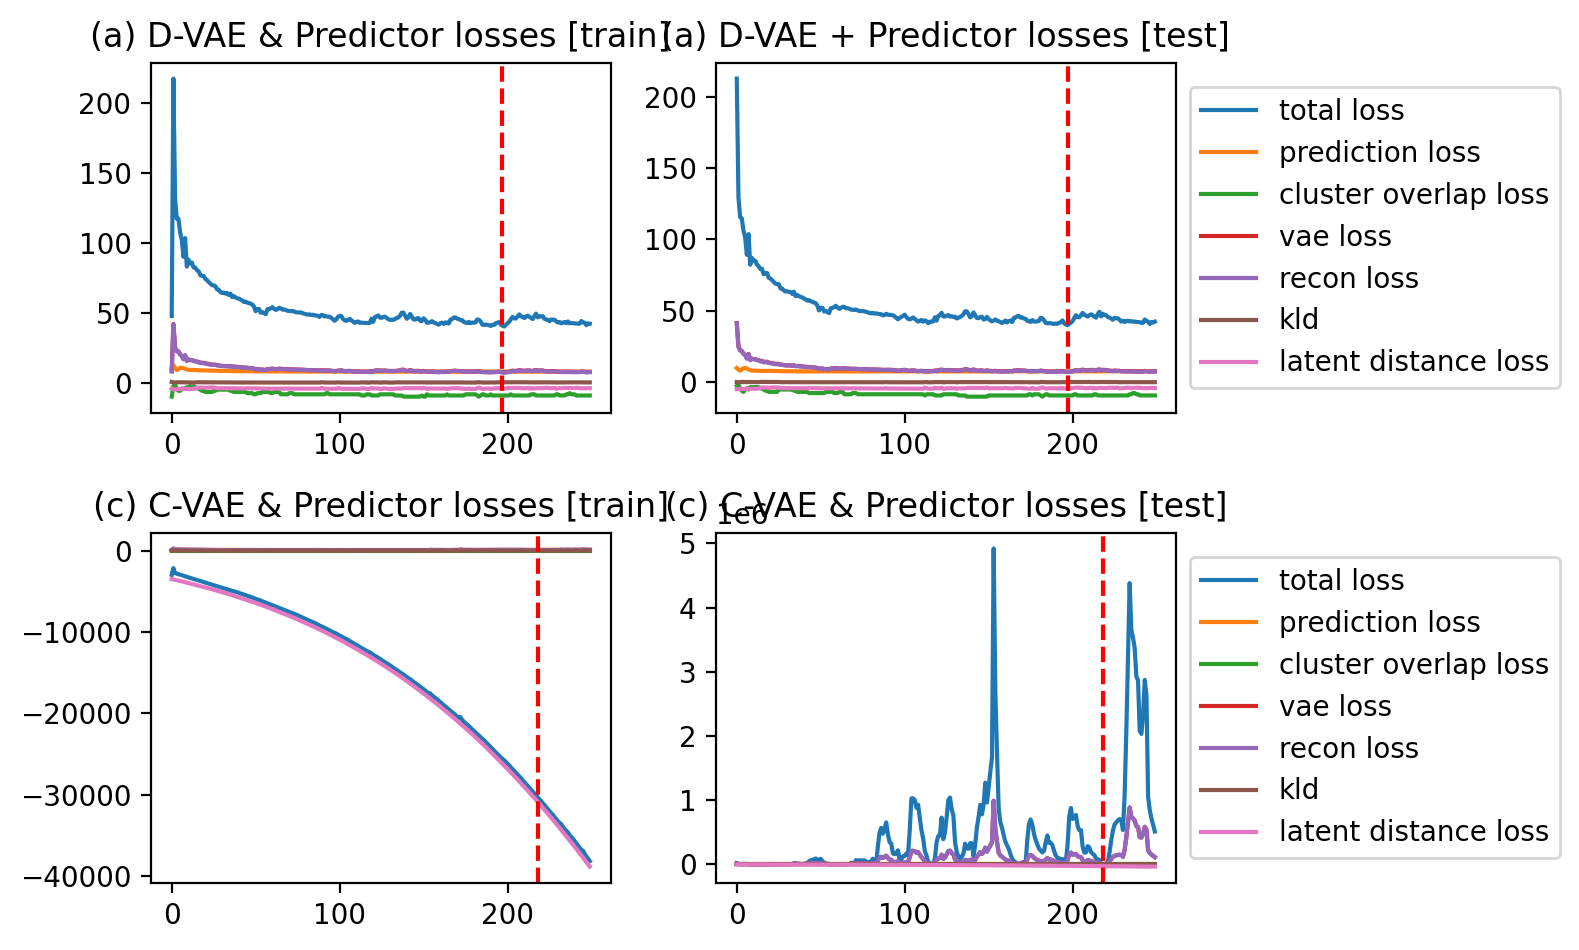

round 4:


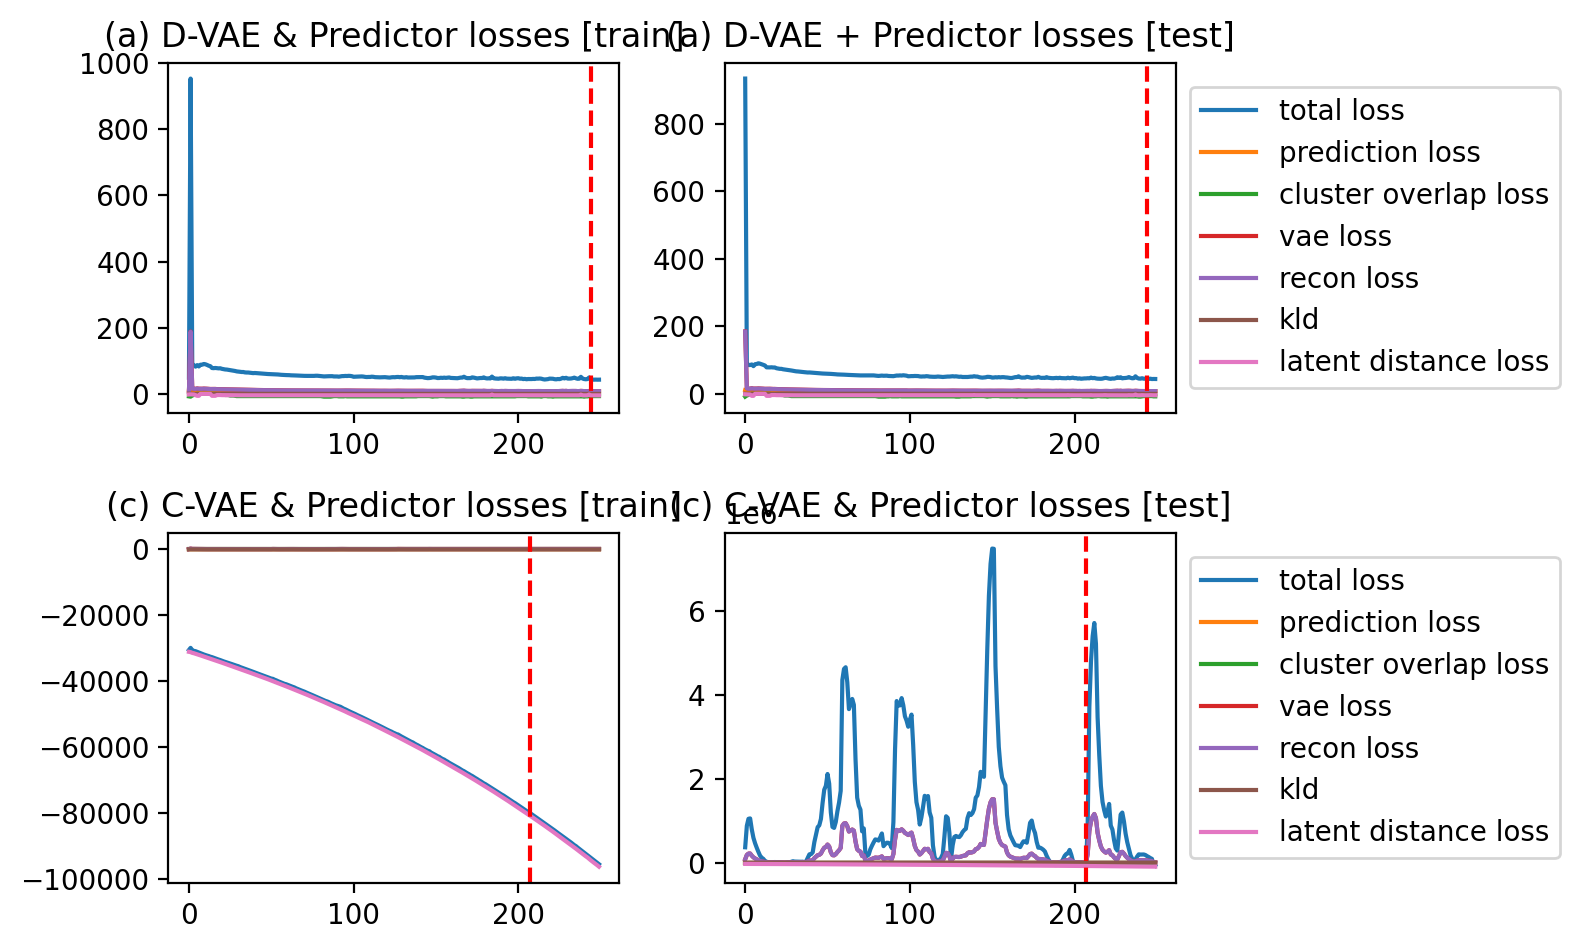

In [ ]:
for k in range(CDPmodel.K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_training_losses_train_test_2cols(losses_train_hist_list[k][b], best_epoch_1round = best_epos_list[k][b],
                                              plot_save_path=f'results/images/GDSC/GDSC_skin_losses_b{b}_k{k}.png')
        
        

### 